First consider an extended Van der Pol Oszillator

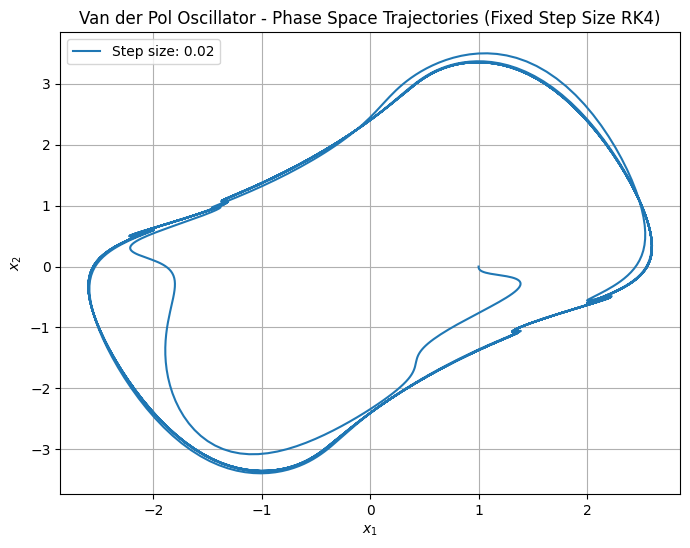

/tmp/ipykernel_11697/2145595403.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

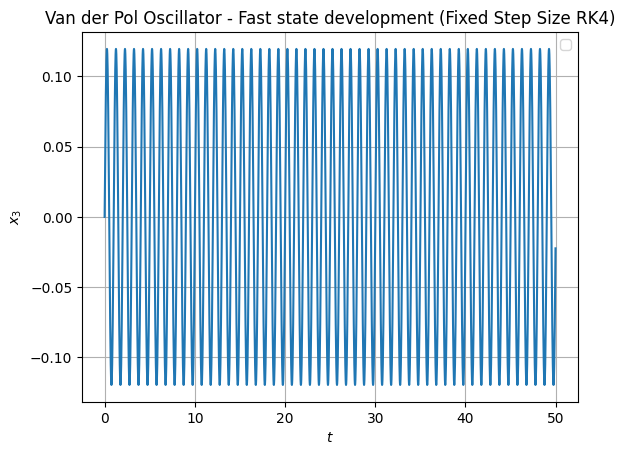

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters
mu = 1.0
epsilon_1, epsilon_2, epsilon_3, epsilon_4 = 10, 0.3, 5, 0.01
d1, d2, d3 = 0.8, 0.8, 40 

# Define periodic control input u
def control_input(t, scale=0.3):
    return scale*np.sin(2 * np.pi * t), scale*np.sin(2 * np.pi * t) # Example: sinusoidal input

# Define the modified Van der Pol oscillator
def van_der_pol(t, X):
    x1, x2, x3 = X
    u_1, u_2 = control_input(t)
    dx1 = x2 + d1 * u_1 + epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + epsilon_3 * x3 + d2 * u_2
    dx3 = - (1 / epsilon_4) * x3 + d3 * u_2
    return np.array([dx1, dx2, dx3])

# Fixed-step RK4 integrator
def rk4_integrate(f, X0, t_span, step_size):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    X_values = np.zeros((len(t_values), len(X0)))
    
    X = np.array(X0)
    for i, t in enumerate(t_values):
        X_values[i] = X
        
        k1 = step_size * f(t, X)
        k2 = step_size * f(t + step_size / 2, X + k1 / 2)
        k3 = step_size * f(t + step_size / 2, X + k2 / 2)
        k4 = step_size * f(t + step_size, X + k3)
        
        X += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # RK4 update rule

    return t_values, X_values

# Initial conditions
X0 = [1.0, 0.0, 0.0]
t_span = (0, 50)  # Time range

# Different step sizes for integration
step_size = 0.02  # Decreasing step sizes, RUKU fails for 0.03

plt.figure(figsize=(8, 6))

# Solve the ODE using RK4 with a fixed step size
t_vals, X_vals = rk4_integrate(van_der_pol, X0, t_span, step_size)

# Extract solutions
x1, x2, x3 = X_vals[:, 0], X_vals[:, 1],  X_vals[:, 2]

# Plot trajectories
plt.plot(x1, x2, label=f"Step size: {step_size}")

# Plot settings
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Van der Pol Oscillator - Phase Space Trajectories (Fixed Step Size RK4)")
plt.legend()
plt.grid()
plt.show()

# Plot the the fast state over time
plt.plot(t_vals, x3)
plt.xlabel("$t$")
plt.ylabel("$x_3$")
plt.title("Van der Pol Oscillator - Fast state development (Fixed Step Size RK4)")
plt.legend()
plt.grid()
plt.show



Next, compare with dynamics obtained when x3 is neglected

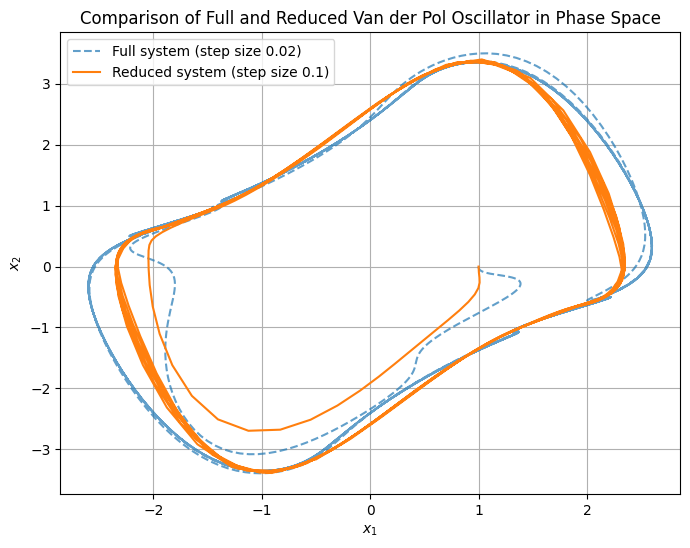

In [2]:
# Define the reduced Van der Pol oscillator (ignoring x3)
def reduced_van_der_pol(t, X):
    x1, x2 = X
    u_1, u_2 = control_input(t)
    dx1 = x2 + d1 * u_1  # Removed epsilon_1 * x3
    dx2 = mu * (1 - x1**2) * x2 - x1 + epsilon_2 * x2 + d2 * u_2  # Removed epsilon_3 * x3
    return np.array([dx1, dx2])

# RK4 integration for the reduced system
def rk4_integrate_reduced(f, X0, t_span, step_size):
    t_values = np.arange(t_span[0], t_span[1], step_size)
    X_values = np.zeros((len(t_values), len(X0)))
    
    X = np.array(X0)
    for i, t in enumerate(t_values):
        X_values[i] = X
        
        k1 = step_size * f(t, X)
        k2 = step_size * f(t + step_size / 2, X + k1 / 2)
        k3 = step_size * f(t + step_size / 2, X + k2 / 2)
        k4 = step_size * f(t + step_size, X + k3)
        
        X += (k1 + 2 * k2 + 2 * k3 + k4) / 6  # RK4 update rule

    return t_values, X_values

# Initial conditions (only x1 and x2)
X0_reduced = [1.0, 0.0]
new_step_size = 0.1  # Choose a new step size

# Integrate the reduced system
t_vals_reduced, X_vals_reduced = rk4_integrate_reduced(reduced_van_der_pol, X0_reduced, t_span, new_step_size)

# Extract solutions
x1_reduced, x2_reduced = X_vals_reduced[:, 0], X_vals_reduced[:, 1]

# Plot comparison of full and reduced system
plt.figure(figsize=(8, 6))

# Plot the full system's trajectory (from the first cell)
plt.plot(x1, x2, label=f"Full system (step size {step_size})", linestyle='dashed', alpha=0.7)

# Plot the reduced system's trajectory
plt.plot(x1_reduced, x2_reduced, label=f"Reduced system (step size {new_step_size})", linestyle='solid')

# Plot settings
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Comparison of Full and Reduced Van der Pol Oscillator in Phase Space")
plt.legend()
plt.grid()
plt.show()



Create and visualize a simple trajectory that we want to track

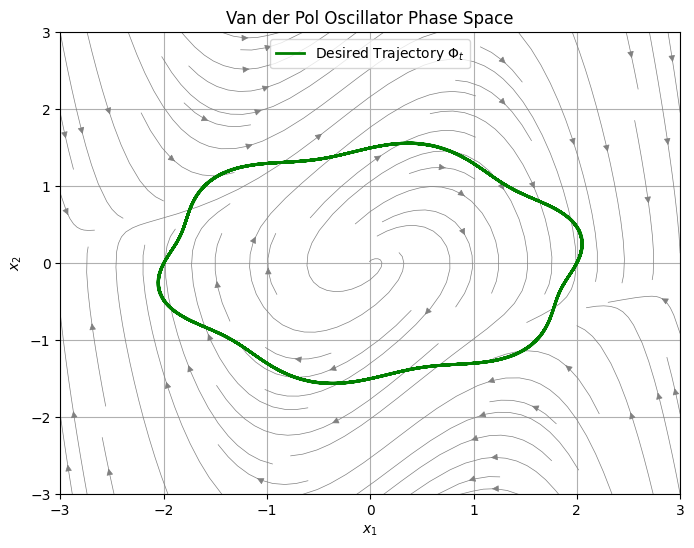

In [3]:
from plotting_utils import plot_phase_space

def Phi_t(t):
    omega_1 = 1  # Base ellipse frequency
    alpha_1 = 2  # Major axis length
    alpha_2 = 1.5  # Minor axis length
    
    beta = 0.1  # Oscillation magnitude
    nu = 6 * omega_1  # Frequency of normal oscillation
    
    # Base ellipse
    x1 = alpha_1 * np.sin(omega_1 * t)
    x2 = alpha_2 * np.cos(omega_1 * t)
    
    # Tangent vector
    Tx = alpha_1 * omega_1 * np.cos(omega_1 * t)
    Ty = -alpha_2 * omega_1 * np.sin(omega_1 * t)
    
    # Normal vector (rotated tangent)
    Nx = alpha_2 * omega_1 * np.sin(omega_1 * t)
    Ny = alpha_1 * omega_1 * np.cos(omega_1 * t)
    
    # Normalize the normal vector
    norm = np.sqrt(Nx**2 + Ny**2)
    Nx /= norm
    Ny /= norm
    
    # Add oscillation in the normal direction
    x1_perturbed = x1 + beta * Nx * np.sin(nu * t)
    x2_perturbed = x2 + beta * Ny * np.sin(nu * t)
    
    return x1_perturbed, x2_perturbed


plot_phase_space(Phi_t)

Next, verify that the Van der Pol MPC class actually works with different configurations


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_vdp_2d.so
rm -f vdp_2d_cost/vdp_2d_cost_y_0_fun.o vdp_2d_cost/vdp_2d_cost_y_0_fun_jac_ut_xt.o vdp_2d_cost/vdp_2d_cost_y_0_hess.o vdp_2d_cost/vdp_2d_cost_y_fun.o vdp_2d_cost/vdp_2d_cost_y_fun_jac_ut_xt.o vdp_2d_cost/vdp_2d_cost_y_hess.o vdp_2d_cost/vdp_2d_cost_y_e_fun.o vdp_2d_cost/vdp_2d_cost_y_e_fun_jac_ut_xt.o vdp_2d_cost/vdp_2d_cost_y_e_hess.o acados_solver_vdp_2d.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/

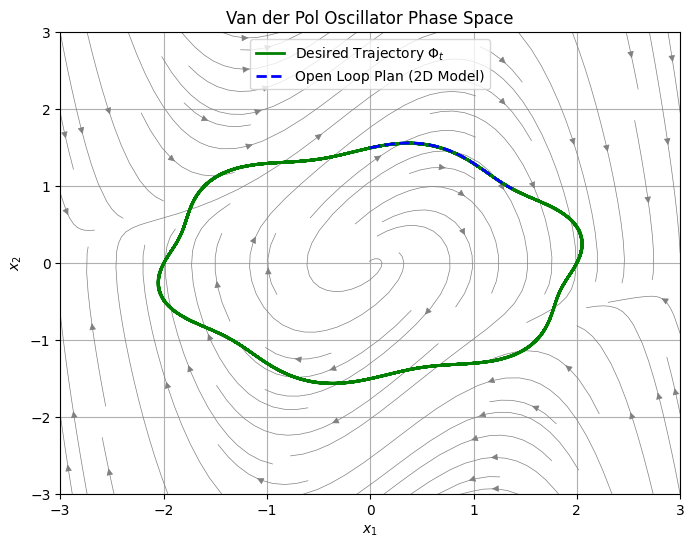

In [4]:
from Van_der_pol_MPC import VanDerPolMPC, VanDerPolMPCOptions

mpc_opts = VanDerPolMPCOptions(
    # dynamics
    mu = mu,
    epsilon_1 = epsilon_1,
    epsilon_2 = epsilon_2,
    epsilon_3 = epsilon_3,
    epsilon_4 = epsilon_4,
    d1 = d1,
    d2 = d2,
    d3 = d3,

    # mpc options
    N = 40,
    step_size_list = [0.02]* 40,
    switch_stage = 0
)
mpc = VanDerPolMPC(mpc_opts, Phi_t)

print('Generated mpc succesfully')

# Set initial state on the trajectory
t0 = 0
x01, x02 = Phi_t(t=t0)
x03 = 0.0
x0 = np.vstack((x01, x02, x03))

# account for the case where only the 2d model is used
if mpc_opts.switch_stage == 0:
    nx0 = 2
else:
    nx0 = 3
mpc.solve(x0[:nx0], t0)

plot_phase_space(Phi_t, mpc, open_loop_plan=True)



Let's simulate in closed loop and see if we succesfully track!

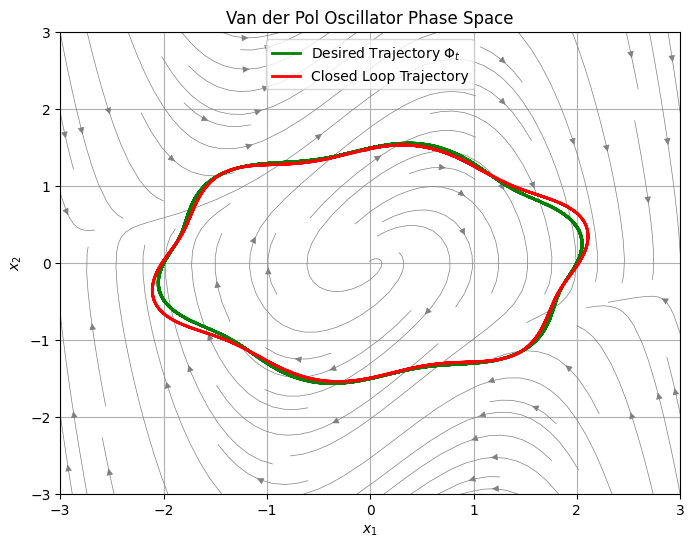

In [5]:
from utils import simulate_closed_loop

duration = 20
x_traj, u_traj = simulate_closed_loop(x0, mpc, duration)

plot_phase_space(Phi_t, mpc, closed_loop_traj=x_traj)

